In [121]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
with open("new_mb_sweep.json", "r") as f:
    df = pd.DataFrame(json.load(f))
df.sort_values("run_id", inplace=True)

# --- Load Known Potential ---
from potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()
known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

# --- Utilities ---
def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

def round_sig(x, sig=5):
    if pd.isna(x):
        return x
    if x == 0:
        return 0
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

# --- Main Loop ---
# --- Main Loop ---
rows = []

for idx, row in df.iterrows():
    # Deduplicate structures
    seed_saddles = row['found_saddles']
    seed_minima = row['found_minima']
    unique_saddles = list({tuple(s) for s in seed_saddles})
    unique_minima = list({tuple(m) for m in seed_minima})

    # Errors to known points
    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in unique_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in unique_minima]

    # Parse force and energy call lists safely
    force_calls_list = row['force_calls_at_each_min']
    energy_calls_list = row['energy_calls_at_each_min']

    if isinstance(force_calls_list, str):
        try:
            force_calls_list = json.loads(force_calls_list)
        except json.JSONDecodeError:
            force_calls_list = []

    if isinstance(energy_calls_list, str):
        try:
            energy_calls_list = json.loads(energy_calls_list)
        except json.JSONDecodeError:
            energy_calls_list = []

    total_force_calls = force_calls_list[-1] if force_calls_list else np.nan
    total_energy_calls = energy_calls_list[-1] if energy_calls_list else np.nan

    # Per-step breakdowns
    per_min_force_calls = cumulative_to_diffs(force_calls_list) if force_calls_list else []
    per_saddle_force_calls = cumulative_to_diffs(force_calls_list[:row['bias_count']]) if force_calls_list else []

    # Summary
    summary = {
        'run_id': row['run_id'],
        'saddle_error_list': saddle_errors,  # <-- New list column
        'saddle_error_mean': np.mean(saddle_errors),
        'saddle_error_stderr': standard_error(saddle_errors),
        'minima_error_mean': np.mean(minima_errors),
        'minima_error_stderr': standard_error(minima_errors),
        'bias_count': row['bias_count'],
        'num_minima': len(unique_minima),
        'num_saddles': len(unique_saddles),
        'total_force_calls': total_force_calls,
        'mean_force_calls_per_min': total_force_calls / len(unique_minima) if len(unique_minima) > 0 else np.nan,
        'stdv_force_calls_per_min': np.std(per_min_force_calls, ddof=1) if len(per_min_force_calls) > 1 else np.nan,
        'mean_force_calls_per_saddle': total_force_calls / len(unique_saddles) if len(unique_saddles) > 0 else np.nan,
        'stdv_force_calls_per_saddle': np.std(per_saddle_force_calls, ddof=1) if len(per_saddle_force_calls) > 1 else np.nan,
        'total_energy_calls': total_energy_calls,
        'bias_std_dev_scale': row['bias_std_dev_scale'],
        'bias_covariance': round(row['bias_covariance'], 6),
        'bias_height_fraction': row['bias_height_fraction'],
        'bias_height': round(row['bias_height'], 6),
        'perturbation_size': round(row['perturbation_size'], 6),
        'optimizer': row['optimizer'],
        'seed': row['seed']
    }

    rows.append(summary)

# --- Final DataFrame ---
full_df = pd.DataFrame(rows)

# Optional: filter for completed runs
full_df = full_df[
    (full_df['num_minima'] == 3) &
    (full_df['num_saddles'] == 2)
].copy()

# Preview
full_df



run_id  saddle_error_mean  saddle_error_stderr  minima_error_mean  \
0          0           0.503677             0.172711       1.661484e-05   
1          1           0.845878             0.177908       4.083858e-04   
2          2           0.747480             0.060610       7.147562e-04   
3          3           0.856977             0.243504       1.938646e-03   
4          4           0.647170             0.454247       1.664383e-05   
...      ...                ...                  ...                ...   
1995    1995           0.317653             0.033208       7.666947e-09   
1996    1996           0.442713             0.178021       2.685225e-09   
1997    1997           0.306235             0.138565       2.862451e-09   
1998    1998           0.443511             0.116524       5.425017e-09   
1999    1999           0.282111             0.036902       4.362444e-09   

      minima_error_stderr  bias_count  num_minima  num_saddles  \
0            1.649954e-05           6           3            2   
1            4.083106e-04           9           3            2   
2            7.144520e-04          16           3            2   
3            1.938592e-03          12           3            2   
4            1.645094e-05          19           3            2   
...                   ...         ...         ...          ...   
1995         5.557063e-09        4221           3            2   
1996         2.478894e-09        4305           3            2   
1997         2.397557e-09        4526           3            2   
1998         5.263796e-09        4186           3            2   
1999         3.445275e-09         775           3            2   

      total_force_calls  mean_force_calls_per_min  ...  \
0                   801                267.000000  ...   
1                  1144                381.333333  ...   
2                  2009                669.666667  ...   
3                  1497                499.000000  ...   
4                  2372                790.666667  ...   
...                 ...                       ...  ...   
1995              95621              31873.666667  ...   
1996              99244              33081.333333  ...   
1997             103145              34381.666667  ...   
1998              95455              31818.333333  ...   
1999              18050               6016.666667  ...   

      mean_force_calls_per_saddle  stdv_force_calls_per_saddle  \
0                           400.5                   267.848838   
1                           572.0                   244.941490   
2                          1004.5                   588.404906   
3                           748.5                   471.685276   
4                          1186.0                  1174.675416   
...                           ...                          ...   
1995                      47810.5                 50688.874532   
1996                      49622.0                 56314.896895   
1997                      51572.5                 47053.120888   
1998                      47727.5                 53921.824499   
1999                       9025.0                  8309.202870   

      total_energy_calls  bias_std_dev_scale  bias_covariance  \
0                    801            0.333333         0.033611   
1                   1144            0.333333         0.033611   
2                   2009            0.333333         0.033611   
3                   1497            0.333333         0.033611   
4                   2372            0.333333         0.033611   
...                  ...                 ...              ...   
1995               95621            0.071429         0.001543   
1996               99244            0.071429         0.001543   
1997              103145            0.071429         0.001543   
1998               95455            0.071429         0.001543   
1999               18050            0.071429         0.001543   

      bias_height_fraction  bias_height  

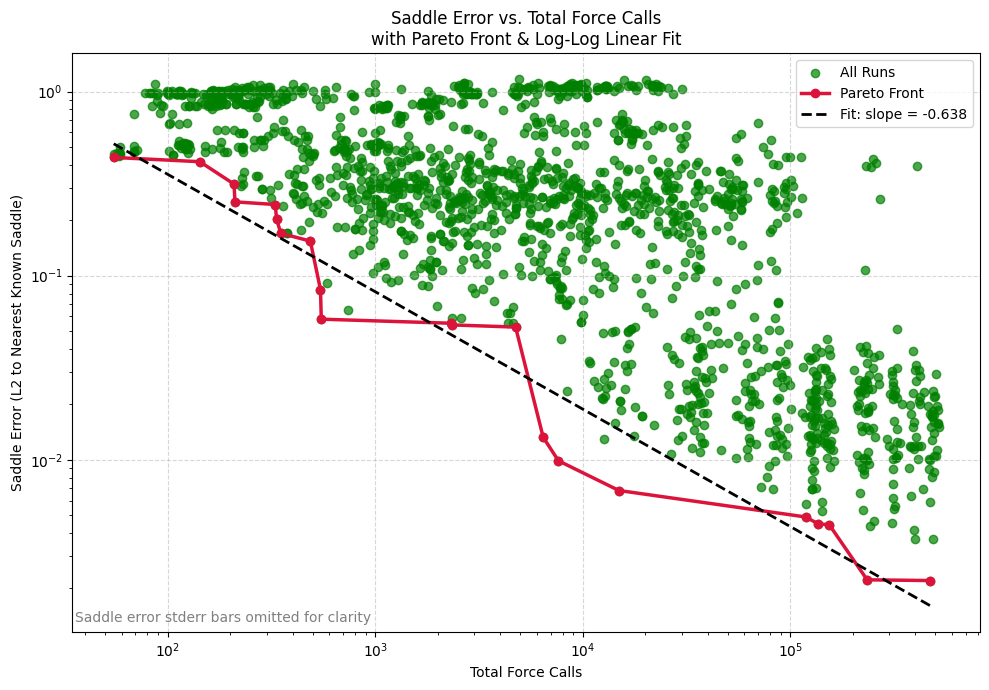

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x and y values
x = np.array(full_df['total_force_calls'])
y = np.array(full_df['saddle_error_mean'])
# yerr = np.array(full_df['saddle_error_stderr'])  # Not used now

# --- Pareto Front Computation ---
def is_pareto_efficient(costs):
    """Return a boolean array indicating Pareto-efficient points."""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Remove points that are dominated
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

# Build the 2D cost array (both axes we want to minimize)
costs = np.vstack((x, y)).T
pareto_mask = is_pareto_efficient(costs)
pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort Pareto front for plotting
sorted_indices = np.argsort(pareto_x)
pareto_x = pareto_x[sorted_indices]
pareto_y = pareto_y[sorted_indices]

# --- Log-Log Linear Regression ---
log_x = np.log10(pareto_x)
log_y = np.log10(pareto_y)

# Fit line: log_y = m * log_x + b
coeffs = np.polyfit(log_x, log_y, 1)
m, b = coeffs

# Generate fit line points
fit_log_x = np.linspace(log_x.min(), log_x.max(), 100)
fit_log_y = m * fit_log_x + b
fit_x = 10**fit_log_x
fit_y = 10**fit_log_y

# --- Plotting ---
plt.figure(figsize=(10, 7))

# All points without error bars (for clarity)
plt.scatter(x, y, color='green', alpha=0.7, label='All Runs')

# Highlight Pareto front
plt.plot(pareto_x, pareto_y, 'o-', color='crimson', linewidth=2.5, markersize=6, label='Pareto Front')

# Plot regression line on Pareto front
plt.plot(fit_x, fit_y, '--', color='black', linewidth=2, label=f'Fit: slope = {m:.3f}')

# Add tiny annotation at bottom right
plt.annotate(
    "Saddle error stderr bars omitted for clarity",
    xy=(0.01, 0), xycoords='axes fraction',
    fontsize=10, color='gray',
    ha='left', va='bottom',
    xytext=(-5, 5), textcoords='offset points'
)

# Labels and formatting
plt.xlabel("Total Force Calls")
plt.ylabel("Saddle Error (L2 to Nearest Known Saddle)")
plt.title("Saddle Error vs. Total Force Calls\nwith Pareto Front & Log-Log Linear Fit")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="major", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\gxn\AppData\Local\Temp\ipykernel_10308\3077527524.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # or any qualitative colormap


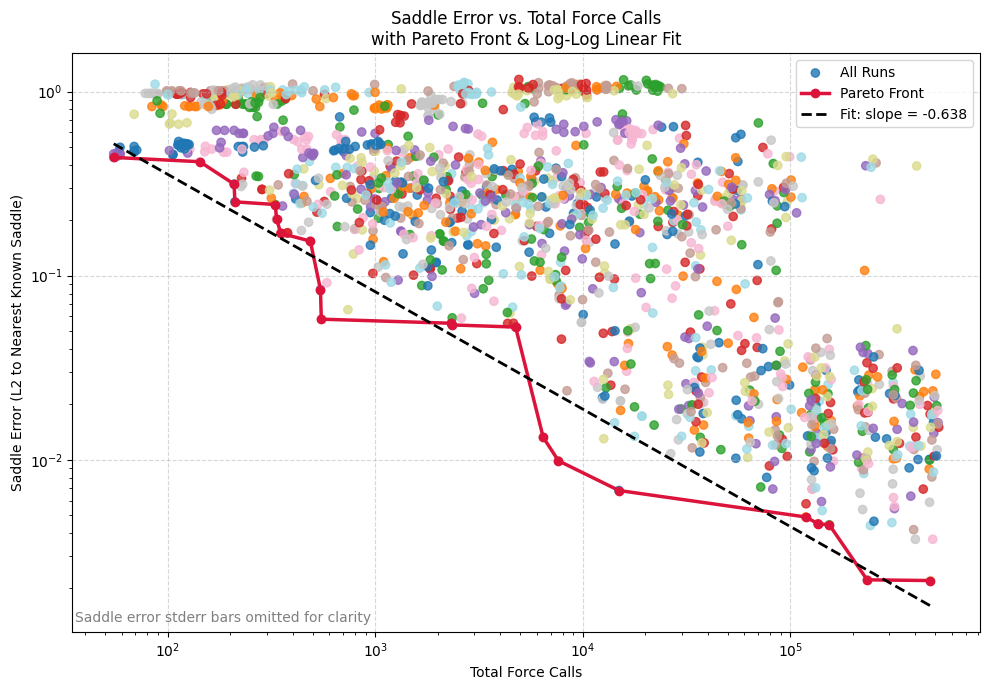

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Extract x, y, and seed values
x = np.array(full_df['total_force_calls'])
y = np.array(full_df['saddle_error_mean'])
seeds = np.array(full_df['seed'])  # Assuming 'seed' column exists

# Normalize seeds for colormap
norm = plt.Normalize(seeds.min(), seeds.max())
cmap = cm.get_cmap('tab20')  # or any qualitative colormap

colors = cmap(norm(seeds))

# --- Pareto Front Computation ---
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

costs = np.vstack((x, y)).T
pareto_mask = is_pareto_efficient(costs)
pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort Pareto front
sorted_indices = np.argsort(pareto_x)
pareto_x = pareto_x[sorted_indices]
pareto_y = pareto_y[sorted_indices]

# --- Log-Log Linear Regression ---
log_x = np.log10(pareto_x)
log_y = np.log10(pareto_y)
coeffs = np.polyfit(log_x, log_y, 1)
m, b = coeffs

fit_log_x = np.linspace(log_x.min(), log_x.max(), 100)
fit_log_y = m * fit_log_x + b
fit_x = 10**fit_log_x
fit_y = 10**fit_log_y

# --- Plotting ---
plt.figure(figsize=(10, 7))

# Scatter all points colored by seed
plt.scatter(x, y, color=colors, alpha=0.8, label='All Runs')

# Highlight Pareto front
plt.plot(pareto_x, pareto_y, 'o-', color='crimson', linewidth=2.5, markersize=6, label='Pareto Front')

# Plot regression line
plt.plot(fit_x, fit_y, '--', color='black', linewidth=2, label=f'Fit: slope = {m:.3f}')

plt.annotate(
    "Saddle error stderr bars omitted for clarity",
    xy=(0.01, 0), xycoords='axes fraction',
    fontsize=10, color='gray',
    ha='left', va='bottom',
    xytext=(-5, 5), textcoords='offset points'
)

plt.xlabel("Total Force Calls")
plt.ylabel("Saddle Error (L2 to Nearest Known Saddle)")
plt.title("Saddle Error vs. Total Force Calls\nwith Pareto Front & Log-Log Linear Fit")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="major", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\gxn\AppData\Local\Temp\ipykernel_10308\1847229943.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


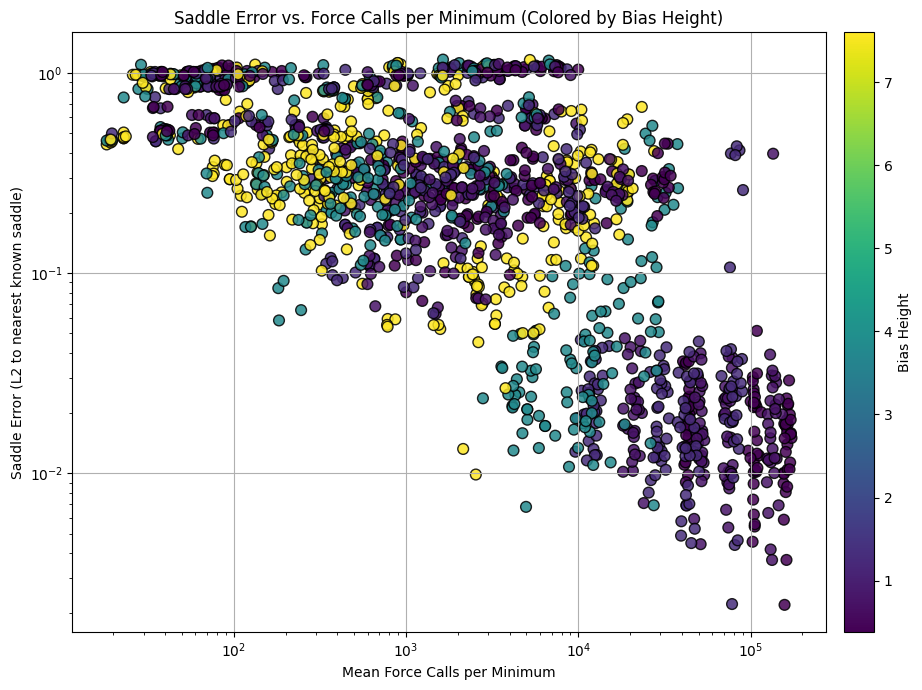

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Normalize bias_height across all individual runs
norm = Normalize(vmin=full_df['bias_height'].min(), vmax=full_df['bias_height'].max())
cmap = get_cmap('viridis')
colors = [cmap(norm(val)) for val in full_df['bias_height']]

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

sc = ax.scatter(
    full_df['mean_force_calls_per_min'],
    full_df['saddle_error_mean'],
    color=colors,
    s=60, alpha=0.85, edgecolors='k'
)

# Axis formatting
ax.set_xlabel("Mean Force Calls per Minimum")
ax.set_ylabel("Saddle Error (L2 to nearest known saddle)")
ax.set_title("Saddle Error vs. Force Calls per Minimum (Colored by Bias Height)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Bias Height")

plt.tight_layout()
plt.show()


C:\Users\gxn\AppData\Local\Temp\ipykernel_10308\3247594877.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(unique_heights))  # discrete colormap


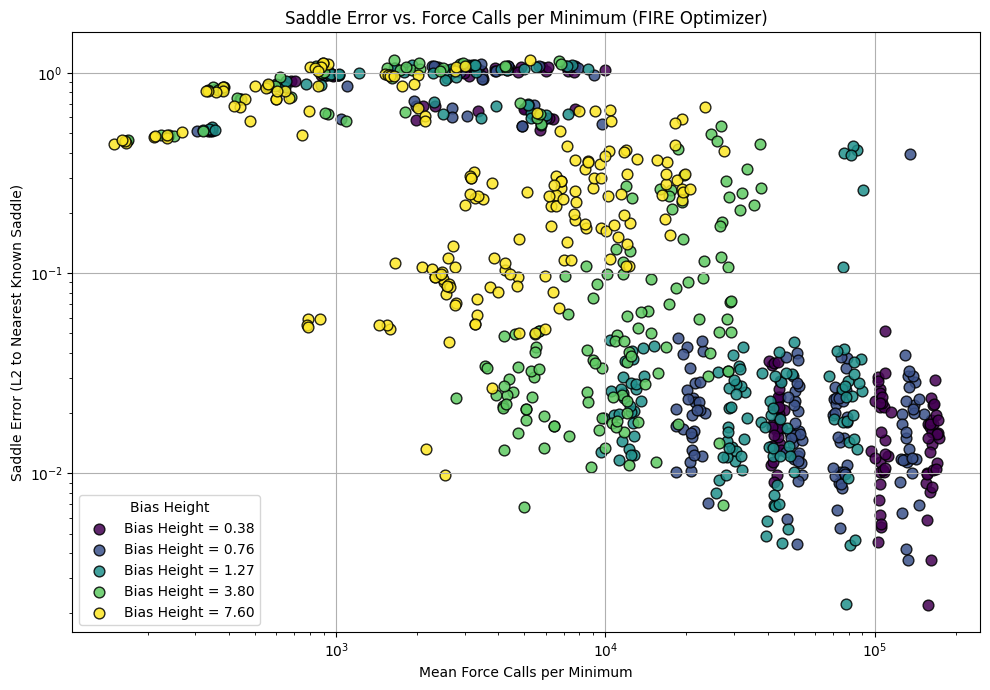

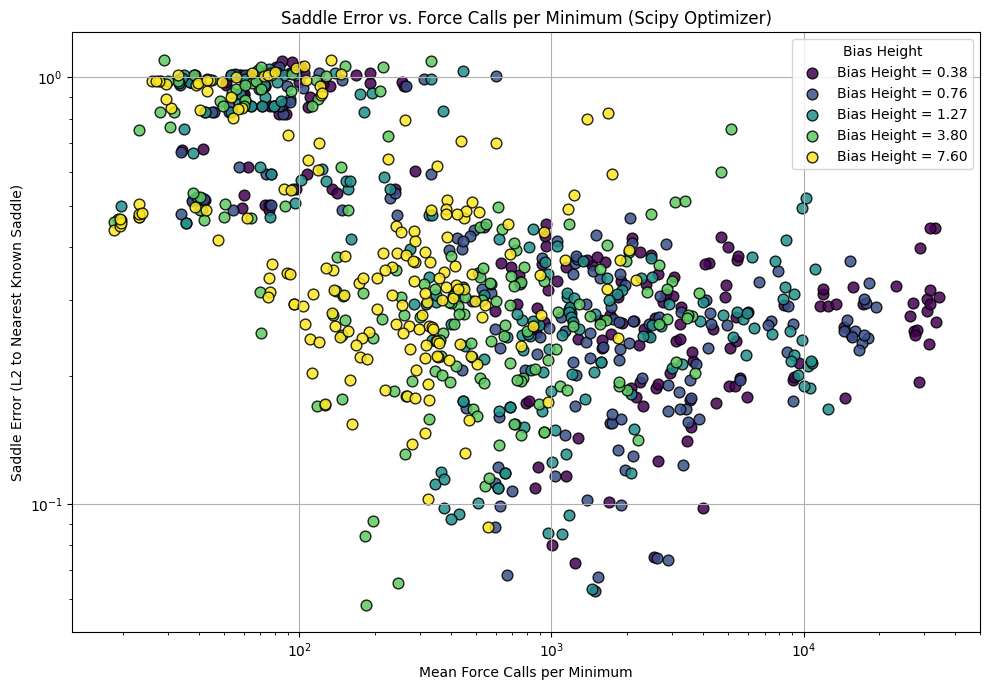

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, to_hex

# --- Optimizers to plot ---
optimizers = ['FIRE', 'Scipy']

# Get distinct, sorted bias heights
unique_heights = sorted(full_df['bias_height'].unique())
cmap = get_cmap('viridis', len(unique_heights))  # discrete colormap
height_to_color = {h: cmap(i) for i, h in enumerate(unique_heights)}

for opt in optimizers:
    subset = full_df[full_df['optimizer'] == opt]

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot each group of same bias height separately, with label
    for h in unique_heights:
        group = subset[subset['bias_height'] == h]
        if group.empty:
            continue
        ax.scatter(
            group['mean_force_calls_per_min'],
            group['saddle_error_mean'],
            color=height_to_color[h],
            label=f'Bias Height = {h:.2f}',
            s=60, alpha=0.85, edgecolors='k'
        )

    # Format axes
    ax.set_xlabel("Mean Force Calls per Minimum")
    ax.set_ylabel("Saddle Error (L2 to Nearest Known Saddle)")
    ax.set_title(f"Saddle Error vs. Force Calls per Minimum ({opt} Optimizer)")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True)

    # Add legend
    ax.legend(title="Bias Height", loc='best', frameon=True)

    plt.tight_layout()
    plt.show()


C:\Users\gxn\AppData\Local\Temp\ipykernel_10308\1362520489.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('plasma', len(unique_covs))  # change colormap if you like


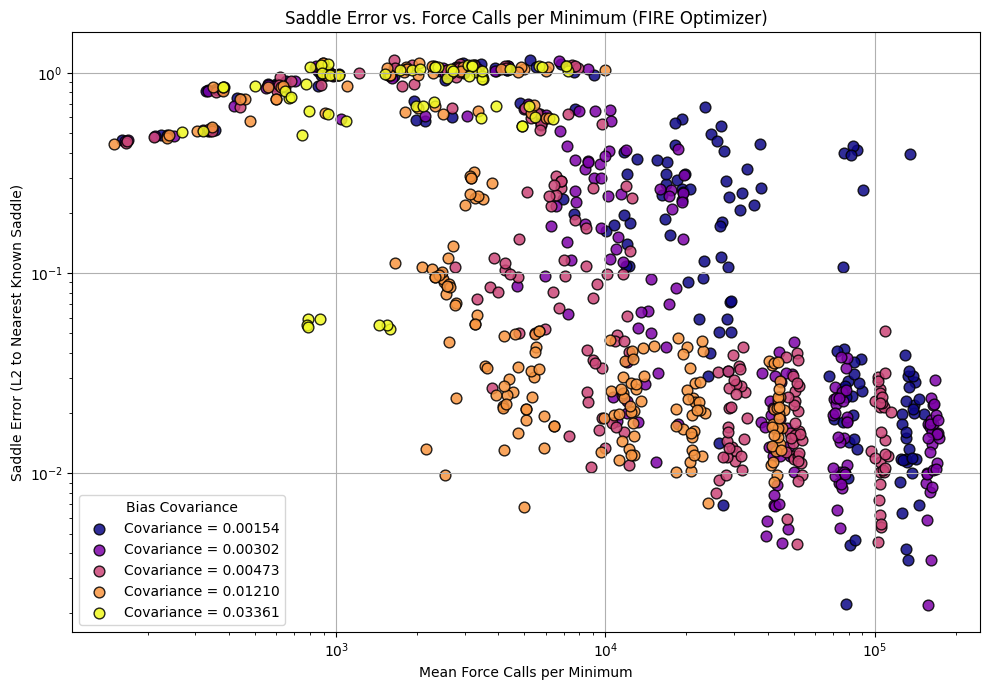

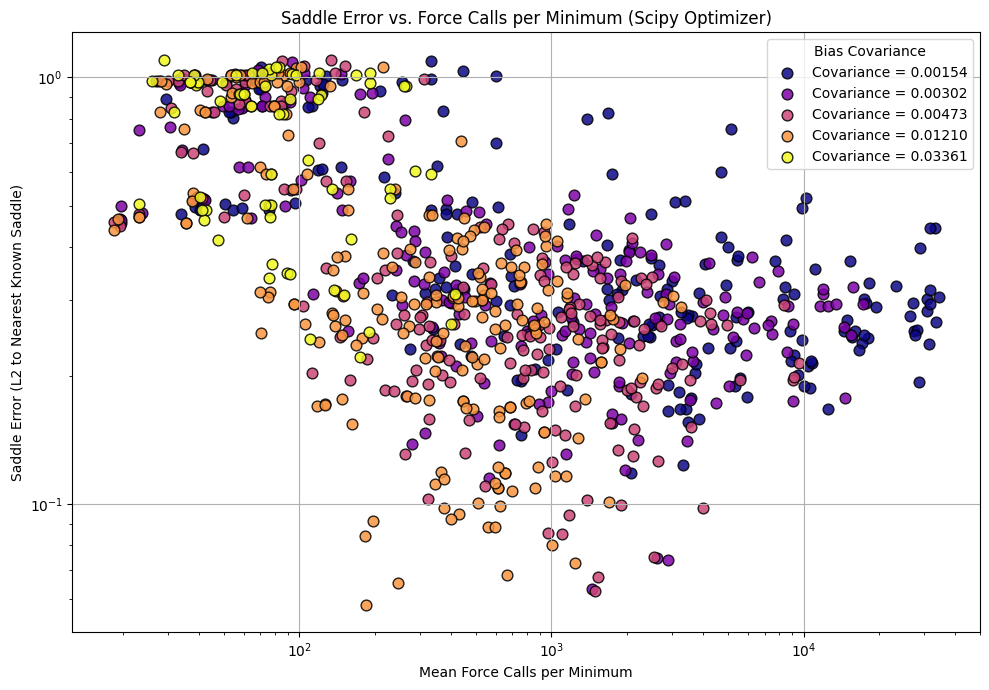

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# --- Optimizers to plot ---
optimizers = ['FIRE', 'Scipy']

# Get distinct, sorted bias_covariance values
unique_covs = sorted(full_df['bias_covariance'].unique())
cmap = get_cmap('plasma', len(unique_covs))  # change colormap if you like
cov_to_color = {c: cmap(i) for i, c in enumerate(unique_covs)}

for opt in optimizers:
    subset = full_df[full_df['optimizer'] == opt]

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot each group of same bias_covariance separately
    for cov in unique_covs:
        group = subset[subset['bias_covariance'] == cov]
        if group.empty:
            continue
        ax.scatter(
            group['mean_force_calls_per_min'],
            group['saddle_error_mean'],
            color=cov_to_color[cov],
            label=f'Covariance = {cov:.5f}',
            s=60, alpha=0.85, edgecolors='k'
        )

    # Format axes
    ax.set_xlabel("Mean Force Calls per Minimum")
    ax.set_ylabel("Saddle Error (L2 to Nearest Known Saddle)")
    ax.set_title(f"Saddle Error vs. Force Calls per Minimum ({opt} Optimizer)")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True)

    # Add legend
    ax.legend(title="Bias Covariance", loc='best', frameon=True)

    plt.tight_layout()
    plt.show()


C:\Users\gxn\AppData\Local\Temp\ipykernel_10308\4220013927.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(unique_vals))


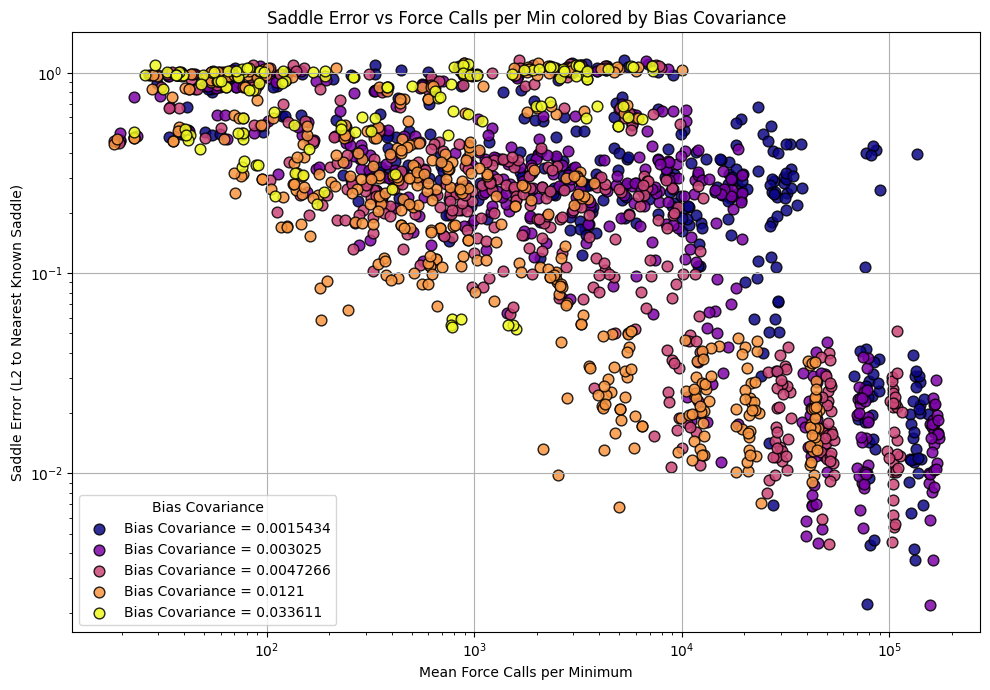

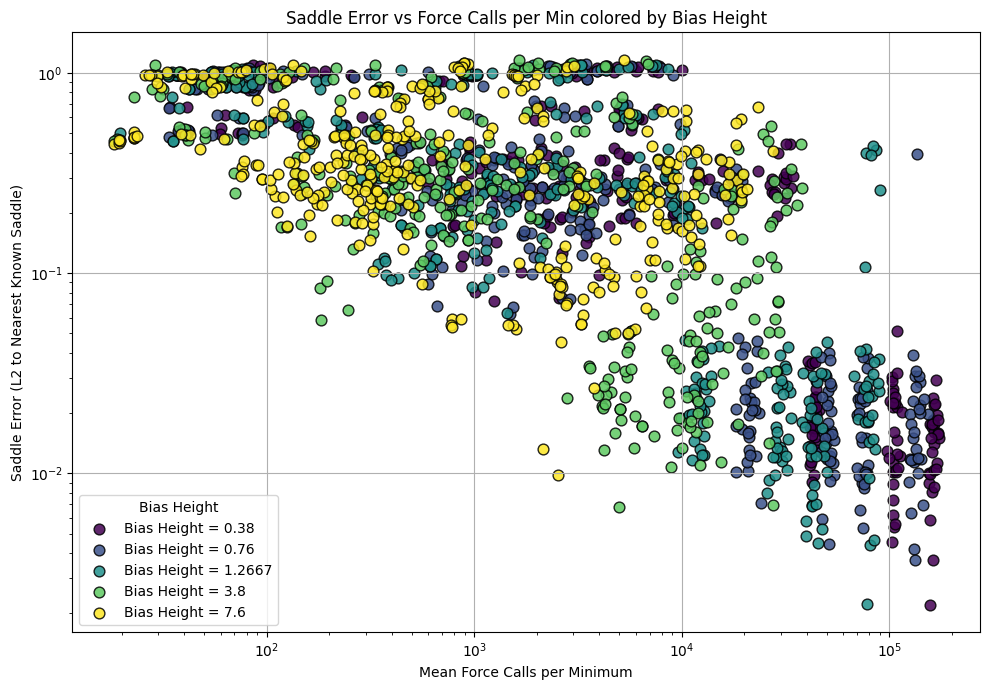

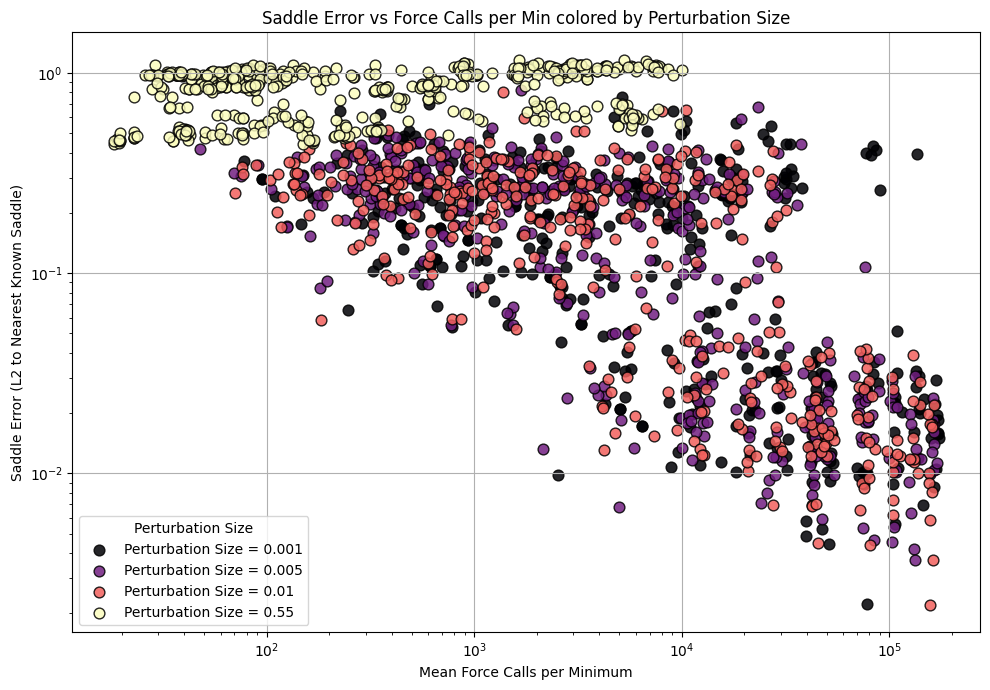

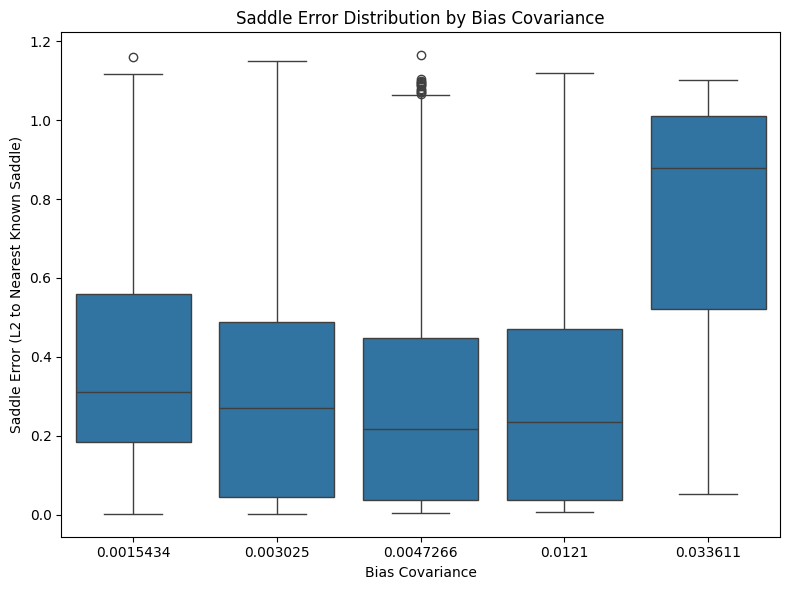

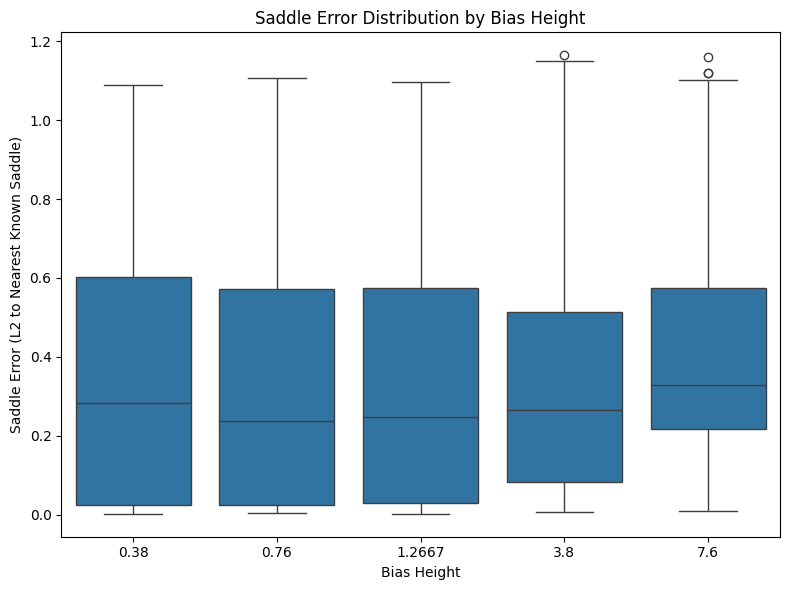

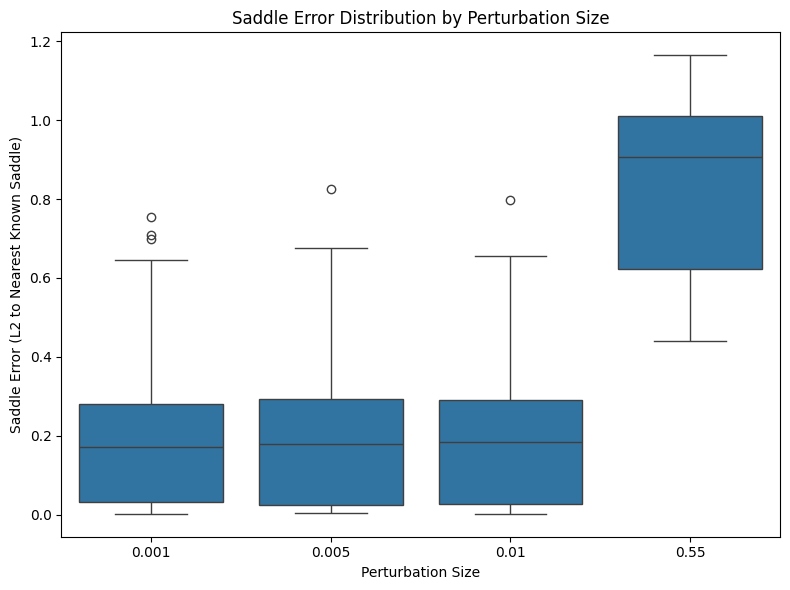

In [47]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def plot_error_vs_calls(df, param, param_name, cmap_name='viridis'):
    unique_vals = sorted(df[param].unique())
    cmap = get_cmap(cmap_name, len(unique_vals))
    val_to_color = {v: cmap(i) for i, v in enumerate(unique_vals)}

    fig, ax = plt.subplots(figsize=(10,7))
    for val in unique_vals:
        sub = df[df[param] == val]
        ax.scatter(
            sub['mean_force_calls_per_min'], 
            sub['saddle_error_mean'], 
            label=f"{param_name} = {val}", 
            color=val_to_color[val],
            alpha=0.85, edgecolors='k', s=60
        )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Mean Force Calls per Minimum")
    ax.set_ylabel("Saddle Error (L2 to Nearest Known Saddle)")
    ax.set_title(f"Saddle Error vs Force Calls per Min colored by {param_name}")
    ax.grid(True)
    ax.legend(title=param_name, loc='best')
    plt.tight_layout()
    plt.show()

# Plot each parameter separately:
plot_error_vs_calls(full_df, 'bias_covariance', 'Bias Covariance', 'plasma')
plot_error_vs_calls(full_df, 'bias_height', 'Bias Height', 'viridis')
plot_error_vs_calls(full_df, 'perturbation_size', 'Perturbation Size', 'magma')

import seaborn as sns

def boxplot_error_by_param(df, param, param_name):
    plt.figure(figsize=(8,6))
    sns.boxplot(x=param, y='saddle_error_mean', data=df)
    # plt.yscale('log')
    plt.xlabel(param_name)
    plt.ylabel("Saddle Error (L2 to Nearest Known Saddle)")
    plt.title(f"Saddle Error Distribution by {param_name}")
    plt.tight_layout()
    plt.show()

boxplot_error_by_param(full_df, 'bias_covariance', 'Bias Covariance')
boxplot_error_by_param(full_df, 'bias_height', 'Bias Height')
boxplot_error_by_param(full_df, 'perturbation_size', 'Perturbation Size')


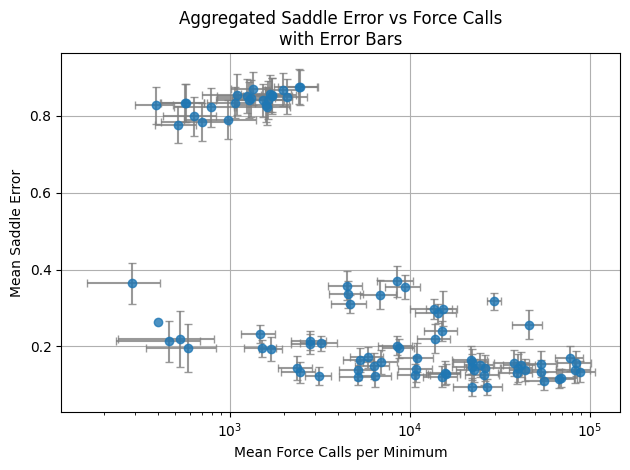

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Group by parameters and aggregate mean and stderr
grouped = full_df.groupby(['bias_covariance', 'bias_height', 'perturbation_size']).agg(
    saddle_error_mean_avg=('saddle_error_mean', 'mean'),
    saddle_error_mean_stderr=('saddle_error_mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_force_calls_per_min_avg=('mean_force_calls_per_min', 'mean'),
    mean_force_calls_per_min_stderr=('mean_force_calls_per_min', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Example plot: saddle error vs force calls, points = parameter combos, with errorbars

plt.errorbar(
    grouped['mean_force_calls_per_min_avg'], grouped['saddle_error_mean_avg'],
    xerr=grouped['mean_force_calls_per_min_stderr'], yerr=grouped['saddle_error_mean_stderr'],
    fmt='o', ecolor='gray', capsize=3, alpha=0.8
)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Mean Force Calls per Minimum')
plt.ylabel('Mean Saddle Error')
plt.title('Aggregated Saddle Error vs Force Calls\nwith Error Bars')
plt.grid(True)
plt.tight_layout()
plt.show()


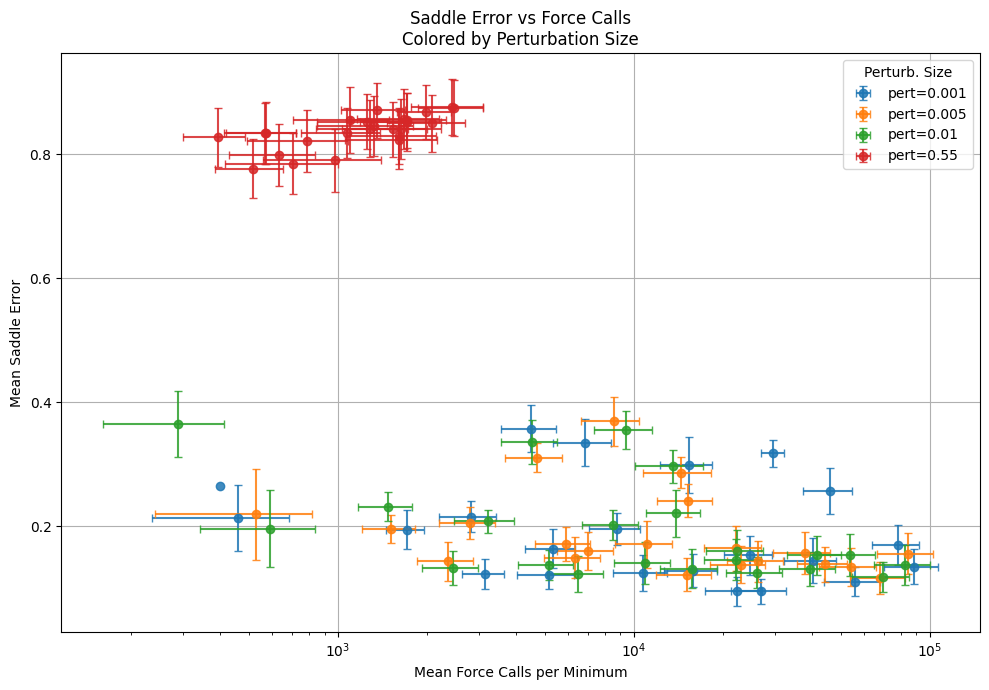

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Group and aggregate
grouped = full_df.groupby(['bias_covariance', 'bias_height', 'perturbation_size']).agg(
    saddle_error_mean_avg=('saddle_error_mean', 'mean'),
    saddle_error_mean_stderr=('saddle_error_mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_force_calls_per_min_avg=('mean_force_calls_per_min', 'mean'),
    mean_force_calls_per_min_stderr=('mean_force_calls_per_min', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Assign a distinct color to each discrete perturbation size, sorted smallest → largest
unique_perturbs = sorted(grouped['perturbation_size'].unique())
color_map = {
    p: color for p, color in zip(
        unique_perturbs,
        plt.cm.tab10.colors[:len(unique_perturbs)]
    )
}

# Plot
plt.figure(figsize=(10, 7))
for p in unique_perturbs:
    df_p = grouped[grouped['perturbation_size'] == p]
    plt.errorbar(
        df_p['mean_force_calls_per_min_avg'],
        df_p['saddle_error_mean_avg'],
        xerr=df_p['mean_force_calls_per_min_stderr'],
        yerr=df_p['saddle_error_mean_stderr'],
        fmt='o',
        label=f"pert={p}",
        capsize=3,
        color=color_map[p],
        alpha=0.85
    )

plt.xscale('log')
plt.xlabel('Mean Force Calls per Minimum')
plt.ylabel('Mean Saddle Error')
plt.title('Saddle Error vs Force Calls\nColored by Perturbation Size')
plt.grid(True)
plt.legend(title='Perturb. Size')
plt.tight_layout()
plt.show()


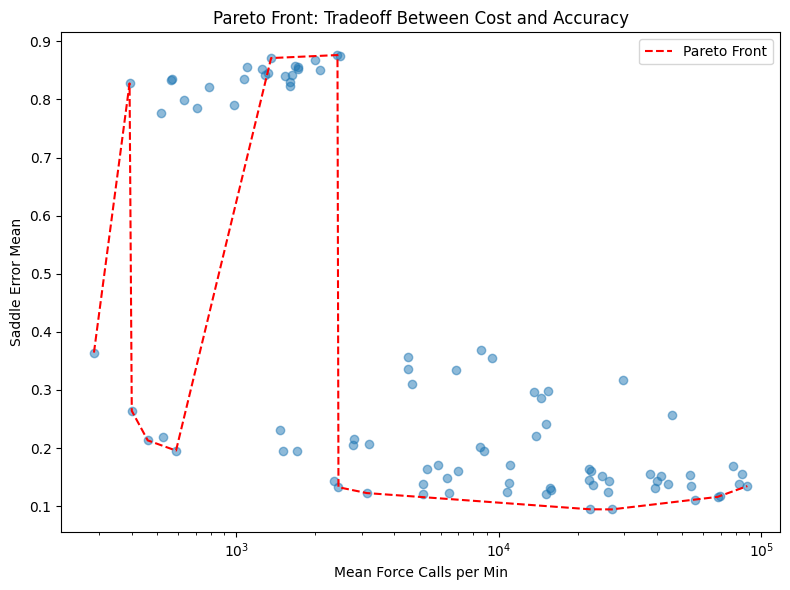

In [87]:
from scipy.spatial import ConvexHull

points = grouped[['mean_force_calls_per_min_avg', 'saddle_error_mean_avg']].values
hull = ConvexHull(points)

pareto_points = points[hull.vertices]
pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]  # sort by x

plt.figure(figsize=(8,6))
plt.scatter(*points.T, alpha=0.5)
plt.plot(*pareto_points.T, 'r--', label='Pareto Front')
plt.xlabel("Mean Force Calls per Min")
plt.ylabel("Saddle Error Mean")
plt.xscale("log")
plt.legend()
plt.title("Pareto Front: Tradeoff Between Cost and Accuracy")
plt.tight_layout()
plt.show()


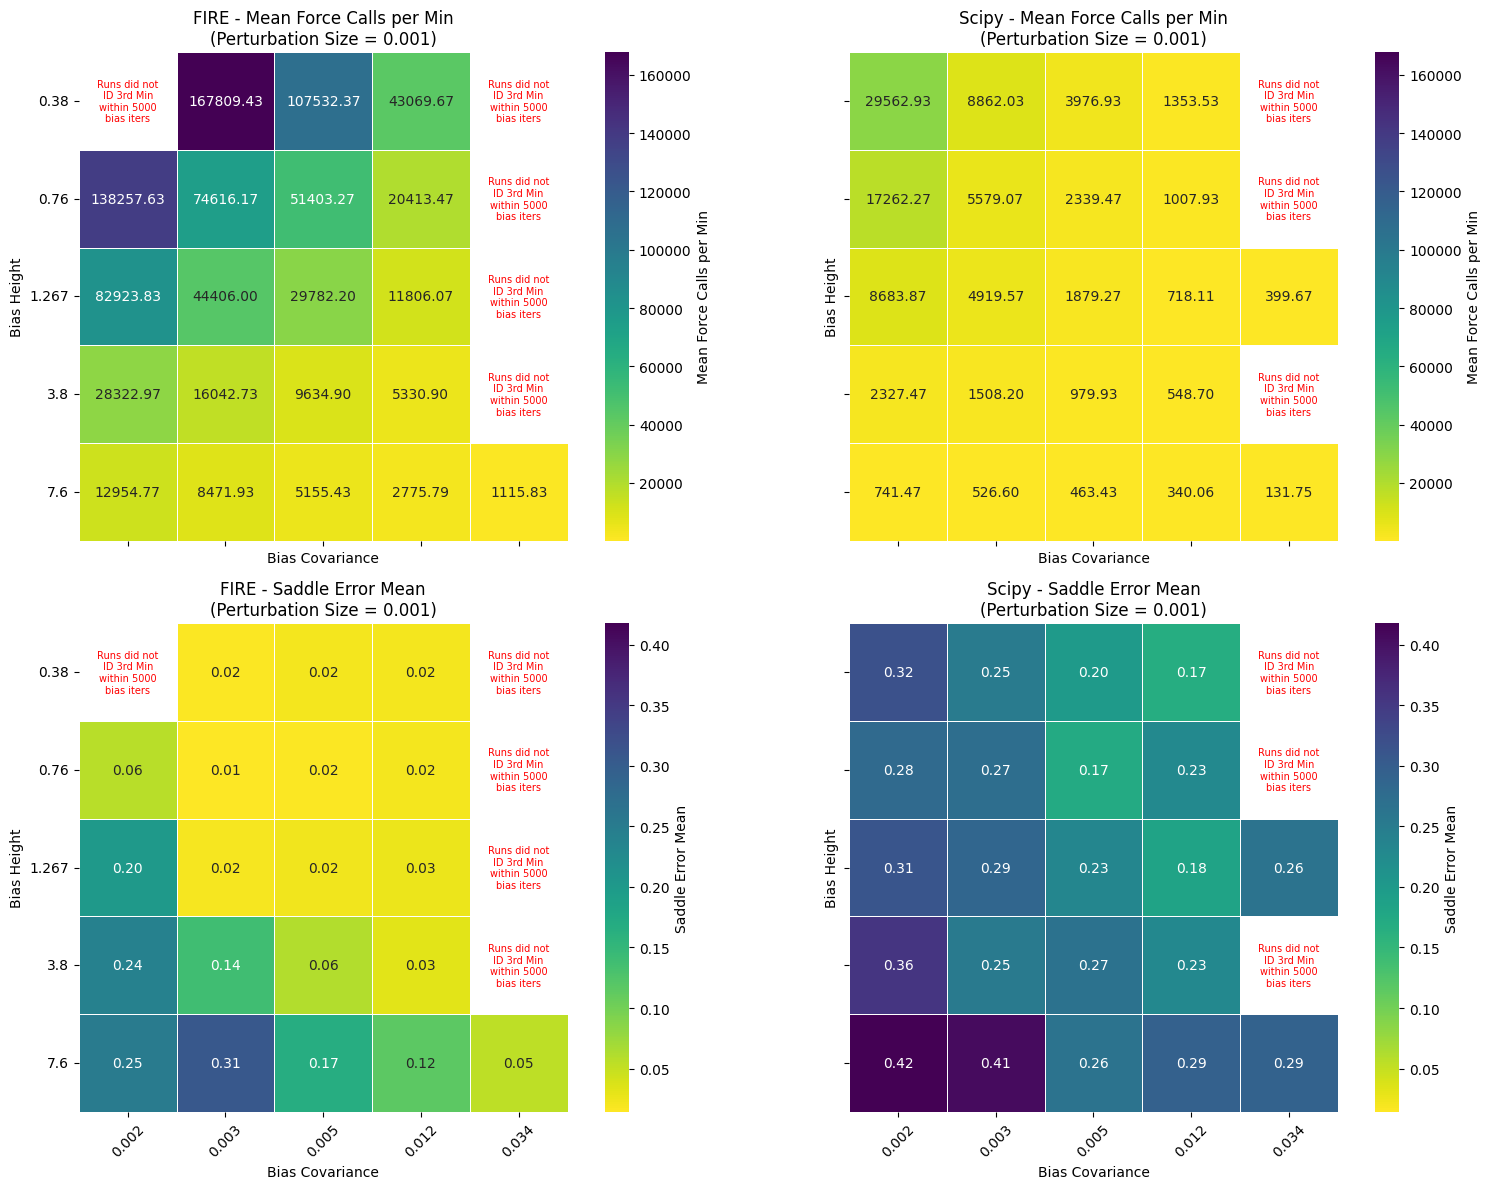

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your full_df assumed already loaded and processed

# Constants
min_perturb_size = full_df['perturbation_size'].min()
missing_msg = "Runs did not\nID 3rd Min\nwithin 5000\nbias iters"

def prepare_heatmap_data(df, optimizer, metric):
    filtered = df[(df['optimizer'] == optimizer) & (df['perturbation_size'] == min_perturb_size)].copy()

    # Round to ~0.001 precision
    filtered['bias_covariance'] = filtered['bias_covariance'].round(3)
    filtered['bias_height'] = filtered['bias_height'].round(3)

    all_cov = np.sort(np.round(full_df['bias_covariance'].unique(), 3))
    all_height = np.sort(np.round(full_df['bias_height'].unique(), 3))

    grouped = filtered.groupby(['bias_covariance', 'bias_height']).agg({
        metric: 'mean'
    }).reset_index()

    grouped['bias_covariance'] = grouped['bias_covariance'].round(3)
    grouped['bias_height'] = grouped['bias_height'].round(3)

    heatmap_data = grouped.pivot(index='bias_height', columns='bias_covariance', values=metric)

    heatmap_data = heatmap_data.reindex(index=all_height, columns=all_cov)

    return heatmap_data, all_cov, all_height

# Prepare data for all four plots
fire_force_calls, covs, heights = prepare_heatmap_data(full_df, 'FIRE', 'mean_force_calls_per_min')
scipy_force_calls, _, _ = prepare_heatmap_data(full_df, 'Scipy', 'mean_force_calls_per_min')
fire_saddle_err, _, _ = prepare_heatmap_data(full_df, 'FIRE', 'saddle_error_mean')
scipy_saddle_err, _, _ = prepare_heatmap_data(full_df, 'Scipy', 'saddle_error_mean')

# Find global min/max for consistent color scaling per metric
force_calls_min = min(fire_force_calls.min().min(), scipy_force_calls.min().min())
force_calls_max = max(fire_force_calls.max().max(), scipy_force_calls.max().max())

saddle_err_min = min(fire_saddle_err.min().min(), scipy_saddle_err.min().min())
saddle_err_max = max(fire_saddle_err.max().max(), scipy_saddle_err.max().max())

# Setup subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)

heatmaps = [
    (fire_force_calls, "FIRE", "Mean Force Calls per Min"),
    (scipy_force_calls, "Scipy", "Mean Force Calls per Min"),
    (fire_saddle_err, "FIRE", "Saddle Error Mean"),
    (scipy_saddle_err, "Scipy", "Saddle Error Mean")
]

for ax, (data, optimizer, metric) in zip(axes.flatten(), heatmaps):
    # Select appropriate vmin/vmax and colormap
    if 'Force Calls' in metric:
        vmin, vmax = force_calls_min, force_calls_max
    else:
        vmin, vmax = saddle_err_min, saddle_err_max

    sns.heatmap(
        data,
        cmap='viridis_r',  # reversed colormap so smaller = bright/yellow
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': metric},
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        square=True,
        ax=ax
    )

    # Annotate missing data cells
    for (i, j), val in np.ndenumerate(data.values):
        if np.isnan(val):
            ax.text(
                j + 0.5,
                i + 0.5,
                missing_msg,
                ha='center',
                va='center',
                fontsize=7,
                color='red',
                rotation=0,
                wrap=True
            )

    ax.set_title(f"{optimizer} - {metric}\n(Perturbation Size = {min_perturb_size})")
    ax.set_xlabel('Bias Covariance')
    ax.set_ylabel('Bias Height')

# Adjust ticks for nicer labeling
cov_labels = np.round(covs, 5)
height_labels = np.round(heights, 5)
for ax in axes[-1, :]:
    ax.set_xticklabels(cov_labels, rotation=45)
for ax in axes[:, 0]:
    ax.set_yticklabels(height_labels, rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# fix perturbation
# fix optimizer
# vary max cov 
# fix height 

# TELL THEM TO USE THE PARETO FIT FUNCTION TO DETERMINE THEIR DESIRED PARAMETERS

# COMPUTE ERROR IN BARRIER HEIGHT AND USE THAT INSTEAD OF DISTANCE 

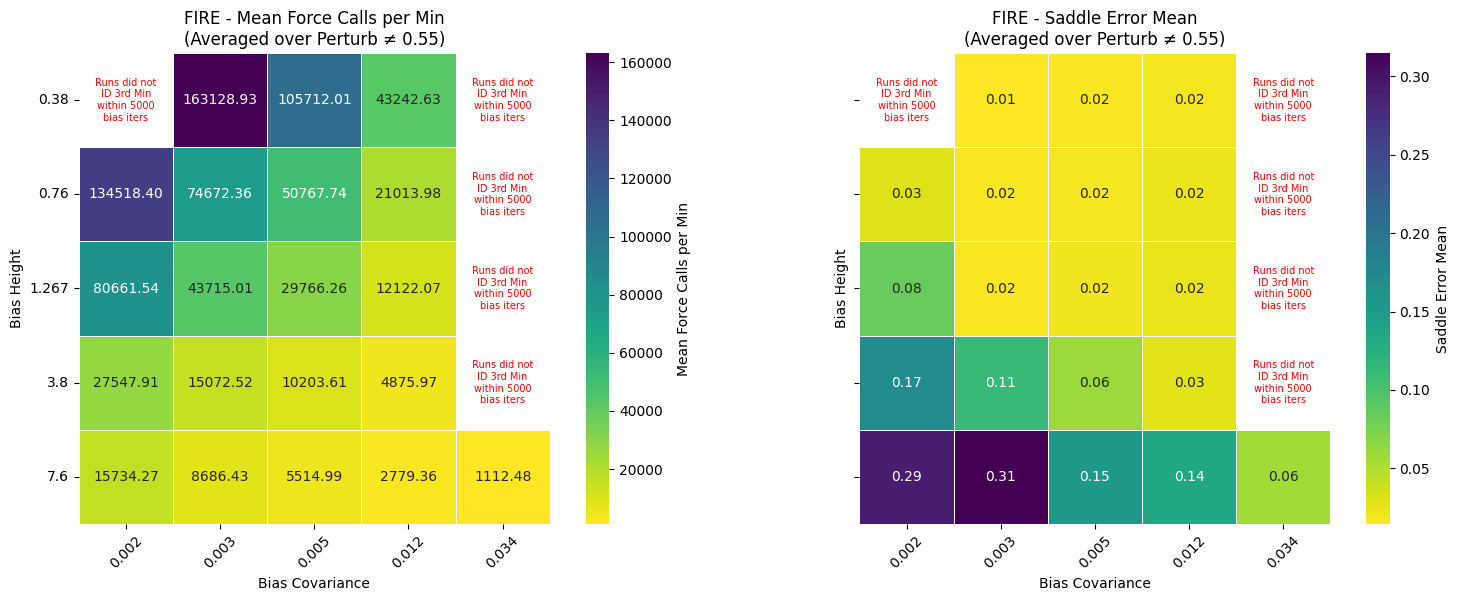

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Constants
missing_msg = "Runs did not\nID 3rd Min\nwithin 5000\nbias iters"
exclude_perturb = 0.55

# Function to prepare data for one optimizer and metric
def prepare_heatmap_data(df, optimizer, metric):
    # Filter
    filtered = df[
        (df['optimizer'] == optimizer) &
        (df['perturbation_size'] != exclude_perturb)
    ].copy()

    # Round for grouping
    filtered['bias_covariance'] = filtered['bias_covariance'].round(3)
    filtered['bias_height'] = filtered['bias_height'].round(3)

    # Ensure full index
    all_cov = np.sort(np.round(df['bias_covariance'].unique(), 3))
    all_height = np.sort(np.round(df['bias_height'].unique(), 3))

    # Group by (bias_covariance, bias_height), averaging over remaining perturb sizes
    grouped = filtered.groupby(['bias_covariance', 'bias_height']).agg({
        metric: 'mean'
    }).reset_index()

    # Pivot to matrix
    heatmap_data = grouped.pivot(index='bias_height', columns='bias_covariance', values=metric)

    # Fill in full grid
    heatmap_data = heatmap_data.reindex(index=all_height, columns=all_cov)

    return heatmap_data, all_cov, all_height

# Prepare both heatmaps for FIRE
fire_force_calls, covs, heights = prepare_heatmap_data(full_df, 'FIRE', 'mean_force_calls_per_min')
fire_saddle_err, _, _ = prepare_heatmap_data(full_df, 'FIRE', 'saddle_error_mean')

# Determine consistent color scaling
force_vmin, force_vmax = fire_force_calls.min().min(), fire_force_calls.max().max()
saddle_vmin, saddle_vmax = fire_saddle_err.min().min(), fire_saddle_err.max().max()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

heatmaps = [
    (fire_force_calls, "Mean Force Calls per Min", force_vmin, force_vmax),
    (fire_saddle_err, "Saddle Error Mean", saddle_vmin, saddle_vmax)
]

for ax, (data, metric, vmin, vmax) in zip(axes, heatmaps):
    sns.heatmap(
        data,
        cmap='viridis_r',  # reversed: smaller = brighter
        vmin=vmin, vmax=vmax,
        cbar_kws={'label': metric},
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        square=True,
        ax=ax
    )

    for (i, j), val in np.ndenumerate(data.values):
        if np.isnan(val):
            ax.text(
                j + 0.5, i + 0.5,
                missing_msg,
                ha='center', va='center',
                fontsize=7, color='red'
            )

    ax.set_title(f"FIRE - {metric}\n(Averaged over Perturb ≠ {exclude_perturb})")
    ax.set_xlabel("Bias Covariance")
    ax.set_ylabel("Bias Height")

# Tick labels
cov_labels = np.round(covs, 3)
height_labels = np.round(heights, 3)
for ax in axes:
    ax.set_xticklabels(cov_labels, rotation=45)
axes[0].set_yticklabels(height_labels, rotation=0)

plt.tight_layout()
plt.show()
